In [11]:
from collections import defaultdict
from datetime import datetime
import math
import sys

from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn

np.set_printoptions(threshold=sys.maxsize)

In [12]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, d0, d1, d2, freeze=False):
        super(TwoLayerNet, self).__init__()
        
        layers = []
        
        lin_layer1 = nn.Linear(d0, d1)        
#         torch.nn.init.normal_(lin_layer1.bias, mean=0., std=np.sqrt(2. / d0))
        torch.nn.init.uniform_(lin_layer1.bias, -np.sqrt(6 / (2 * d0)), np.sqrt(6 / (2 * d0)))
        torch.nn.init.kaiming_uniform_(lin_layer1.weight, nonlinearity='relu')        
#         torch.nn.init.kaiming_normal_(lin_layer1.weight, nonlinearity='relu')
        if freeze:
            lin_layer1.bias.requires_grad = False
            lin_layer1.weight.requires_grad = False
        layers.append(lin_layer1)
        layers.append(nn.ReLU())
        
        lin_layer2 = nn.Linear(d1, d2, bias=False)
#         torch.nn.init.normal_(lin_layer2.weight, mean=0., std=np.sqrt(1. / d1))
        torch.nn.init.uniform_(lin_layer2.weight, -np.sqrt(6 / (2 * d0)), np.sqrt(6 / (2 * d0)))
        # Freeze the weights in the last layer
        lin_layer2.weight.requires_grad = False
        layers.append(lin_layer2)
        
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    

class PolynomialRegression:

    def __init__(self, coef_lb, coef_ub, degree, d0):
        coef_arr = np.random.uniform(coef_lb, coef_ub, degree + 1)
        self.polynomial = np.polynomial.Polynomial(coef_arr)

    def __call__(self, x):
        return np.sum(self.polynomial(x), axis=-1)
    
    
def get_gaussian_data_np(d0, data_size, target_fn):
    x = np.random.uniform(-1., 1., size=(data_size, d0))
#     x = np.random.normal(size=(data_size, d0))
    y = target_fn(x)
    return x, y
    
def get_gaussian_data(d0, data_size, target_fn):
    x = torch.tensor(np.random.normal(size=(data_size, d0)), dtype=torch.float)
    y = target_fn(x)
    return x, y

def get_A(model, x):
    return model.layers[0](x).detach().numpy() > 0

def get_A_rank(model, x):
    d0 = x.size()[1]
    if d0 == 1:
        pattern = model.layers[0](x).detach().numpy() > 0
        return np.linalg.matrix_rank(pattern.astype(np.float64))
    
    jacobian = []
    for one_x in x:
        model(one_x).backward()        
        grads = [param.grad.view(-1) for param in model.parameters() if param.grad is not None]
        jacobian.append(torch.cat(grads).numpy())
        
    jacobian = np.asarray(jacobian)
#     return np.linalg.matrix_rank(jacobian)
    return np.linalg.matrix_rank(jacobian.astype(np.float64))

def contains_min(model, x, y, solver='linear regression'):    
    N = x.size()[0]
    d0 = x.size()[1]
    d1 = len(model.layers[0].weight)
    
    out1 = model.layers[0](x).detach().numpy()    
    pattern = out1 > 0
    
    w = model.layers[0].weight.detach().numpy().astype(np.float64)
    b = model.layers[0].bias.detach().numpy().astype(np.float64)
    v = model.layers[2].weight.detach().numpy().astype(np.float64)
    x_np = x.detach().numpy().astype(np.float64)
    y_np = y.detach().numpy().astype(np.float64)
    
    # Check the number of dead neurons
    false_dict = defaultdict(int)
    for x_pattern in pattern:
        for pi, p in enumerate(x_pattern):
            if not p:
                false_dict[pi] += 1
    dead_id = [ni for ni in false_dict if false_dict[ni] == N]
    
    # Construct x for the linear regression problem
    # Construct the bias part
    alive_v = np.asarray([[one_v for vi, one_v in enumerate(v[0]) if vi not in dead_id]])
    alive_pattern = np.asarray([
        [one_p for pi, one_p in enumerate(p_row) if pi not in dead_id] for p_row in pattern])
    masked_v = np.concatenate([alive_v for _ in range(N)])
    masked_v[np.invert(alive_pattern)] = 0.
    masked_v = np.expand_dims(masked_v, 1)
     
    # Construct the weight part
    w_alive_pattern = np.concatenate([np.expand_dims(alive_pattern, 1) for _ in range(d0)], 1)
    masked_vx = np.expand_dims(x_np, -1) @ alive_v
    masked_vx[np.invert(w_alive_pattern)] = 0.
    
    x_tilde = np.concatenate((masked_v, masked_vx), axis=1)
    x_tilde = np.reshape(x_tilde, (N, -1))
    
    if solver == 'linear regression':
        beta_hat, _, _, _ = np.linalg.lstsq(x_tilde, y_np, rcond=None)
    else:
        ########################################################
        # Find the quadratic problem solution
        P = matrix(x_tilde.T @ x_tilde)
        q = matrix(- x_tilde.T @ y_np)
        param_num = P.size[1]
        dead_num = len(dead_id)
        active_num = d1 - dead_num
        neuron_param_num = 1 + d0
        
        G = np.zeros((N * active_num, param_num))
        for xi, x_pattern in enumerate(alive_pattern):
            for pi, param_pattern in enumerate(x_pattern):
                # wx + b > 0
                if param_pattern:
                    G[xi * active_num + pi][pi] = -1
                    for wi in range(d0):
                        G[xi * active_num + pi][active_num * (wi + 1) + pi] = -x_np[xi][wi]
                # wx + b <= 0
                else:
                    G[xi * active_num + pi][pi] = 1
                    for wi in range(d0):
                        G[xi * active_num + pi][active_num * (wi + 1) + pi] = x_np[xi][wi]
        G = matrix(G)
        h = matrix(np.zeros(N * active_num))

        beta_hat = np.array(solvers.qp(P, q, G, h)['x'])
        ########################################################
        ########################################################
        ########################################################    
        
    # Check loss
    pred_y = x_tilde @ beta_hat    
    loss = np.mean((pred_y - y_np)**2)
    print(f'loss:{loss}')
    zero_loss = np.isclose(loss, 0)
        
    # Check activation pattern of the found solution
    new_weight = w.copy()
    new_bias = b.copy()
    dead_count = 0
    for ni in range(d1):
        if ni not in dead_id:
            new_bias[ni] = beta_hat[ni - dead_count]#[0]
            for wi in range(d0):
                new_weight[ni][wi] = beta_hat[(1 + wi) * (d1 - len(dead_id)) + ni - dead_count]
        else:
            dead_count += 1
    
    new_out = x_np @ new_weight.T + new_bias   
    new_pattern = new_out > 0
    
    same_pattern = tuple(pattern.reshape(-1)) == tuple(new_pattern.reshape(-1))
        
    parameter_dim = len(model.layers[0].weight) * 2
    eq_num = np.sum(np.isclose(np.min(np.abs(out1), axis=-1), 0))
    region_dim = parameter_dim - eq_num
        
    return loss, zero_loss, same_pattern, region_dim, new_pattern

!!! d1: 25
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 30
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 40
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 50
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Averag

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 60
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 70
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 80
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0



Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 100
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

f

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 80
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 100
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

fu

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 80
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 100
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

fu

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 70
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 80
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 100
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

ful

!!! d1: 25
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 30
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 40
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 50
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, True, True, False, False, True, True, True, True, True]
!!! d1: 50
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 30
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 40
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, Tr

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, False, True, True, False, True, False, True, True, False]
!!! data_size: 400
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, False, False, True, False]
!!! d1: 75
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 30
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, Tru

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, True, False, False, False, False, False, True, True, False]
!!! data_size: 390
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, False, False, True, True, False, True, True, False, True]
!!! data_size: 400
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, True, False, False, True, False, False, False, False]
!!! d1: 100
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank a

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, False, False, True, False, False, False, False, False, False]
!!! data_size: 380
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, True, False, False, False, False, False, False, False]
!!! data_size: 390
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, True, False, False, True, True, False, False, False, False]
!!! data_size: 400
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, True, False, True]
!!! d1: 125
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 370
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, True, True, False, False, False, True, True, False]
!!! data_size: 380
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, True, False, False, False, False, False, False, False]
!!! data_size: 390
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [False, False, False, False, False, False, False, False, False, False]
!!! data_size: 400
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 360
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 370
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 380
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 390
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 350
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 360
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 370
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 380
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 340
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 350
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 360
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 370
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 330
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 340
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 350
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 360
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 320
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 330
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 340
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 350
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 310
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 320
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 330
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 340
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 300
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 310
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 320
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 330
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 290
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 300
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 310
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 320
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 280
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 290
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 300
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 310
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 270
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 280
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 290
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 300
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 260
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 270
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 280
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 290
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 250
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 260
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 270
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 280
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 240
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 250
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 260
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 270
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 240
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 250
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 260
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 240
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 250
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 240
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 170
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 160
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 150
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 140
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 100
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 130
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 100
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 120
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, T

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 80
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 100
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 110
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, Tr

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 70
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 80
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 100
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, Tru

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 60
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 70
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 80
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 90
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 50
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 60
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 70
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 80
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 40
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 50
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 60
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 70
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 40
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 50
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 60
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 70
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 40
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 50
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 60
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 70
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True

!!! d1: 25
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 30
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 40
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 50
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! d1: 50
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 30
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 40
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True,

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 400
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! d1: 75
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 30
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 390
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 400
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! d1: 100
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 20
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, Tr

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 380
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 390
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 400
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! d1: 125
!!! data_size: 10
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, T

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 370
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 380
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 390
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 400
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 360
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 370
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 380
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 390
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 350
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 360
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 370
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 380
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 340
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 350
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 360
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 370
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 330
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 340
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 350
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 360
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 320
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 330
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 340
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 350
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 310
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 320
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 330
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 340
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 300
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 310
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 320
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 330
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 290
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 300
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 310
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 320
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 280
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 290
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 300
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 310
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 270
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 280
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 290
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 300
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 260
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 270
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 280
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 290
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 250
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 260
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 270
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 280
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 240
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 250
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 260
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 270
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 240
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 250
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 260
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 240
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 250
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 240
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 230
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 220
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 180
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 190
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 200
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, True, True, True, True, True, True]
!!! data_size: 210
Number of global minima: 0/10
Number of same patterns: 0/10
Unique lr patterns: 0/10
Average region dimension: 0.0

full rank arr: [True, True, True, True, 

KeyboardInterrupt: 

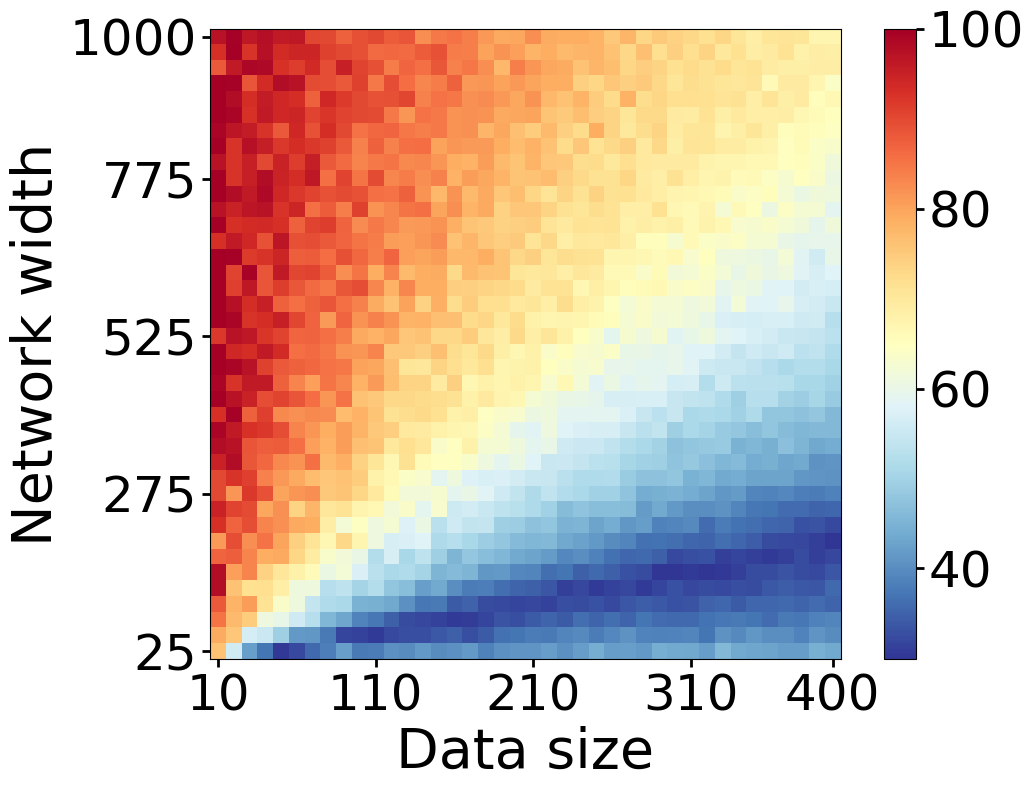

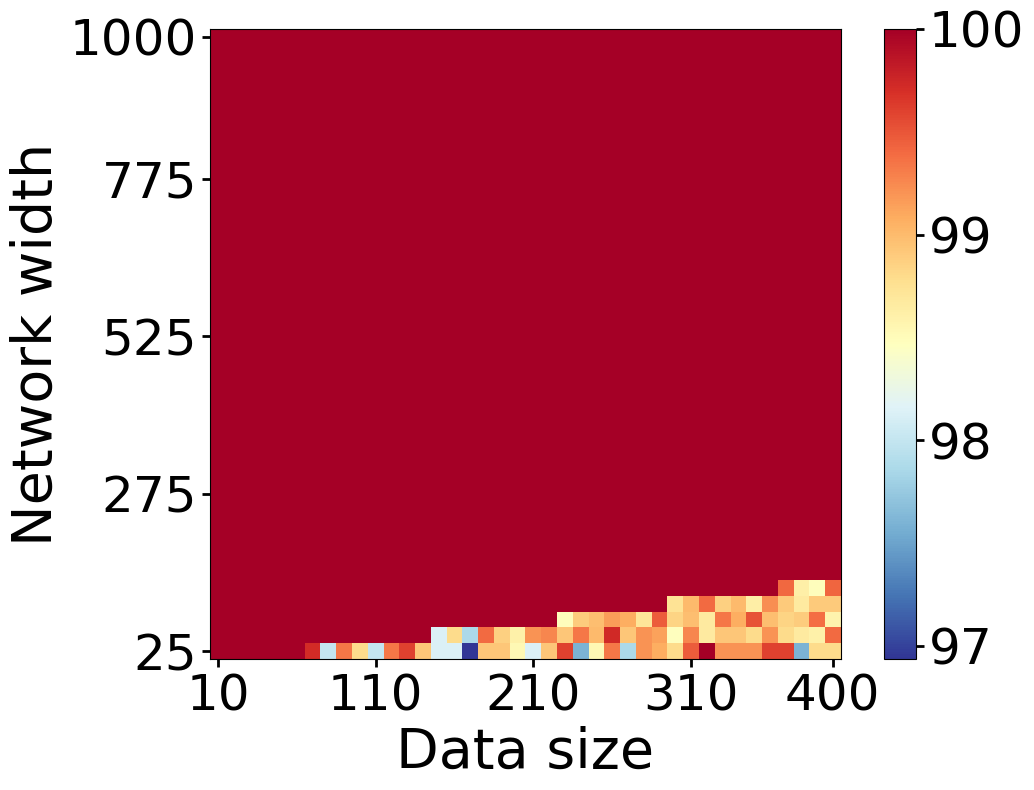

In [13]:
def plot_colormap(data, filename, d0, set_cbar=True):
    colormap_arr = ['RdYlBu_r']
    step = 10

    for colormap in colormap_arr:
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

        fig = plt.figure(figsize=(10.7, 8), dpi=100)
        ax = fig.add_subplot(111)
        ax.tick_params(axis='both', which='major', labelsize=36)
        ax.tick_params(axis='both', which='minor', labelsize=36)
        ax.tick_params(length=6, width=2)

        plt.xlabel('Data size', size=40)
        plt.ylabel('Network width', size=40)
        plt.margins(x=0)

        plt.xticks(list(range(0, len(data_size_arr) , step)) + [len(data_size_arr) - 1],
                   [d for di, d in enumerate(data_size_arr) if di % step == 0] + [data_size_arr[-1]])
        plt.yticks(list(range(0, len(d1_arr), step)) + [len(d1_arr) - 1],
                   [d for di, d in enumerate(d1_arr) if di % step == 0] + [d1_arr[-1]])
        
        if set_cbar:
            cp = plt.imshow(data, cmap=colormap, origin='lower', interpolation='nearest', vmax=100)#, vmin=0,
                            #vmax=100)
            cbar = fig.colorbar(cp)#, ticks=[0, 20, 40, 60, 80, 100])
        else:
            cp = plt.imshow(data, cmap=colormap, origin='lower', interpolation='nearest')
            cbar = fig.colorbar(cp)
        cbar.ax.tick_params(length=6, width=2)

        cbar.ax.tick_params(labelsize=36)
        plt.tight_layout()

        plt.savefig(f'images/random_local_or_global/{timestamp}_d0_{d0}_{filename}_{colormap}.png')
        
# D0 = 1
# # DATA = 'polynomial regression' # 'teacher-student'
DATA = 'teacher-student'
SOLVER = 'quadratic'#'linear regression'
RUNS_NUM = 10

d0_arr = [1, 2, 5 ,10]#[1, 2, 5, 10, 50]
d1_arr = [25 + 25 * (i) for i in range(40)]
data_size_arr = [10 + 10 * (i) for i in range(40)]

for d0 in d0_arr:
    total_zero_loss = []
    total_same_pattern = []
    total_region_dim = []
    total_A_rank = []
    total_full_rank = []
    total_all_rank = []
    total_average_rank = []

    for d1 in d1_arr:
        print(f'!!! d1: {d1}')
        d1_zero_loss = []
        d1_same_pattern = []
        d1_region_dim = []
        d1_A_rank = []
        d1_full_rank = []
        d1_all_rank = []
        d1_average_rank = []
        for data_size in data_size_arr:
            print(f'!!! data_size: {data_size}')

            if DATA == 'polynomial regression':
                x, y = get_gaussian_data_np(
                    d0=d0,
                    data_size=data_size,
                    target_fn=PolynomialRegression(coef_lb=-1., coef_ub=1., degree=2, d0=D0)
                )
                x = torch.tensor(x, dtype=torch.float)
                y = torch.tensor(y, dtype=torch.float)
            elif DATA == 'teacher-student':
                teacher_net = TwoLayerNet(d0=d0, d1=d1, d2=1, freeze=True)
                teacher_net.train(False)
                x, y = get_gaussian_data(d0=d0, data_size=data_size, target_fn=teacher_net)
            else:
                raise Exception(f'Wrong data name \"{DATA}\"')        

            original_pattern_arr = []
            same_pattern_arr = np.asarray([False for _ in range(RUNS_NUM)])
            region_dim_arr = np.zeros(RUNS_NUM)
            zero_loss_arr = np.asarray([False for _ in range(RUNS_NUM)])
            lr_pattern_arr = []
            A_rank_arr = []
            full_rank_arr = []
            all_rank_arr = []

            run_id = 0
            while len(original_pattern_arr) < RUNS_NUM:
                if (run_id + 1) % 100 == 0:
                    print(f'=== Run {run_id + 1}/{RUNS_NUM} ===')
                model = TwoLayerNet(d0=d0, d1=d1, d2=1) 
                pattern_hash = hash(tuple(get_A(model, x).reshape(-1)))
                if pattern_hash not in original_pattern_arr:
                    original_pattern_arr.append(pattern_hash)
#                     (_, zero_loss_arr[run_id], same_pattern_arr[run_id],
#                      region_dim_arr[run_id], lr_pattern) = contains_min(model, x, y, SOLVER)
#                     lr_pattern_arr.append(hash(tuple(lr_pattern.reshape(-1))))

                    A_rank = get_A_rank(model, x)
#                     print(f'd0: {d0}, d1:{d1}, data_size: {data_size}, A_rank: {A_rank},'
#                           +f' min(d1 + d1 * d0, data_size): {min(d1 + d1 * d0, data_size)}'
#                          + f' A_rank / min(d1 + d1 * d0, data_size) * 100: {
#                                         A_rank / min(d1 + d1 * d0, data_size) * 100}')
                    A_rank_arr.append(A_rank / min(d1 + d1 * d0, data_size) * 100)
                    full_rank_arr.append(A_rank == min(d1 + d1 * d0, data_size))
                    all_rank_arr.append(A_rank)
                    run_id +=1

            print(f'Number of global minima: {np.sum(zero_loss_arr)}/{RUNS_NUM}')
            print(f'Number of same patterns: {np.sum(same_pattern_arr)}/{RUNS_NUM}')
            print(f'Unique lr patterns: {np.unique(lr_pattern_arr).shape[0]}/{RUNS_NUM}')
            print(f'Average region dimension: {np.mean(region_dim_arr)}')
            print()

            print(f'full rank arr: {full_rank_arr}')

            d1_zero_loss.append(np.mean(zero_loss_arr) * 100)
            d1_same_pattern.append(np.mean(same_pattern_arr) * 100)
            d1_region_dim.append(np.mean(region_dim_arr))
            d1_A_rank.append(np.mean(A_rank_arr))
            d1_full_rank.append(np.mean(full_rank_arr) * 100)
            d1_all_rank.append(all_rank_arr)
            d1_average_rank.append(np.mean(all_rank_arr))

        total_zero_loss.append(d1_zero_loss)
        total_same_pattern.append(d1_same_pattern)
        total_region_dim.append(d1_region_dim)
        total_A_rank.append(d1_A_rank)
        total_full_rank.append(d1_full_rank)
        total_all_rank.append(all_rank_arr)
        total_average_rank.append(d1_average_rank)

    total_zero_loss = np.asarray(total_zero_loss)
    # print(f'total_zero_loss:\n{total_zero_loss.shape}')
    print(f'total_zero_loss:\n{total_zero_loss}')
    print(f'total_same_pattern:\n{total_same_pattern}')
    print(f'total_region_dim:\n{total_region_dim}')
    print(f'total_A_rank:\n{total_A_rank}')
    print(f'total_full_rank:\n{total_full_rank}')
    print(f'total_all_rank:\n{total_all_rank}')
    print(f'total_average_rank:\n{total_average_rank}')

#     plot_colormap(total_zero_loss, filename='global_percentage', d0=d0)
    plot_colormap(total_A_rank, filename='full_rank_percentage', d0=d0)
#     plot_colormap(total_full_rank, filename='full_rank_out_of_all', d0=d0)
#     plot_colormap(total_average_rank, filename='average_rank', d0=d0, set_cbar=False)